*Goal*: find out if the dataset fits the data requirements

*Data Requirements*:
* user activity is >80% of all time intervals
* month 1, user has >5 rates
* month 0, to pre-train model
* items are comparable
* timestamp
* implicit feedback
* ranking problem


*Conclusion*:
* sample from 2014-06 until 2016-11
* semester frequency
* 1st semester, 2014-06 to 2014-11, will be used to adress the cold start problem
* 2014-12 to 2016-11 is to train the data (why 2016-11?***)
* frequent user threshold of 3/4, in other words, 3 semesters out of the 4 in the years 2015 and 2016
* results from cell:

7368 users of 640186 (1.1509155151784012%) in 75.0% or more semesters in 2015 and 2016 (43394.0 interactions)

Number of interactions per semester in 2015 and 2016:\
4    10677.0\
5    12092.0\
6    11013.0\
7     9612.0\
dtype: float64

(why 2016-11?*** it's a mistake. I included 2012-12 in the data thinking Dec of 2012 would be used for coldstart purposes. The get_interactions_info(), after 1 week!!!!, returned the info, amoung which the timestamps starting at that month. Once I get to run code in parallel, I'll re-run everything)

# update sys.path

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

# imports

In [2]:
import pandas as pd 
# from data_utils import get_namepaths_amazon_digimusic_isgd
from data_utils import getDF
from dataset_evaluation_utils import * # filter_out_users_with_less_than_k_rates, split_timestamp, sample_time_period, get_interactions_info

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

___
# Amazon Digital Music
Small subset, ratings only.  


Ratings only: These datasets include no metadata or reviews, but only (item,user,rating,timestamp) tuples. 


https://nijianmo.github.io/amazon/index.html

## define variables

In [3]:
dataset_name = 'Amazon_Digital_Music'
user_col = 'user_id'
item_col = 'item_id'
rate_col = 'rating'
time_col = 'timestamp'

In [4]:
output_path = 'output/amazon_digmusic_dump/'

sample = 'sample_2012-12_until_2017-01'
sample_1516 = 'sample_2014-06_until_2016-11+cold_start'
sample_15 = 'sample_2015-01_until_2016-01'


## read data

In [5]:
orig_df = pd.read_csv("../datasets/Digital_Music.csv", 
                            names=[item_col, user_col, rate_col, time_col])

orig_df.head()

,item_id,user_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


In [6]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584082 entries, 0 to 1584081
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   item_id    1584082 non-null  object 
 1   user_id    1584082 non-null  object 
 2   rating     1584082 non-null  float64
 3   timestamp  1584082 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 48.3+ MB


In [7]:
orig_df[user_col] = orig_df[user_col].astype(str)#'category')
orig_df[item_col] = orig_df[item_col].astype(str)#'category')
#.apply(lambda x : str(x))

# how many interactions per time unit for a given user?

## remove duplicates? flag remove_duplicated_interactions

In [8]:
remove_duplicated_interactions = False
# duplicate entries -> how many times the user has seen the same item in the same day

In [9]:
# there is a lot of duplicate entries...
orig_df[[user_col, item_col, time_col]].value_counts()

user_id               item_id     timestamp 
A3DG93E8TXMKZF        B001KOWH0G  1397520000    51
A23OB9FM3MUYXT        B00137ILRS  1332979200    18
                      B00137MMAU  1332115200    10
AWG2O9C42XW5G         9434682614  1396396800    10
A23OB9FM3MUYXT        B000VWMT7Y  1333324800    10
                                                ..
A3HWICCEA97SZ6        B00Y41VJ4M  1442534400     1
A3HWIG1CF0EYBA        B00NAPZIIG  1431734400     1
A3HWIHF2G2TQRH        B000VZIO0W  1421884800     1
                      B014EPXN64  1463702400     1
A00041408PB8URN3FSQ6  B003YPD15E  1436140800     1
Length: 1518306, dtype: int64

In [10]:
orig_df.loc[(orig_df[user_col]=='A3DG93E8TXMKZF') &
        (orig_df[item_col]=='B001KOWH0G') &
          (orig_df[time_col]==1397520000), rate_col].value_counts()

1.0    51
Name: rating, dtype: int64

In [11]:
orig_df.duplicated().any()

True

In [12]:
if remove_duplicated_interactions:
    data_clean = orig_df[~orig_df.duplicated()]
    print('is there duplicated interactions user A, item alpha, rate x, time z? ',data_clean.duplicated().any())
    print('percentage of rows kept: ', data_clean.shape[0]/orig_df.shape[0])
else:
    data_clean = orig_df.copy()
    print('is there duplicated interactions user A, item alpha, rate x, time z? ', data_clean.duplicated().any())
    print('duplicate entries NOT deleted')

is there duplicated interactions user A, item alpha, rate x, time z?  True
duplicate entries NOT deleted


## split_timestamp

In [13]:
data_clean = split_timestamp(data_clean)
data_clean.head()

,item_id,user_id,rating,timestamp,date,year-month,year,month,day
2092,9714721180,A2SY49Z6H96QVR,5.0,877305600,1997-10-20,1997-10-01,1997,10,20
83632,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
147526,B0013D89TW,A2XT7XLQ8DD4NZ,5.0,880675200,1997-11-28,1997-11-01,1997,11,28
117999,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22
54105,B00122Z4Y2,A3OS0Q4XX0QSA4,5.0,893203200,1998-04-22,1998-04-01,1998,4,22


# stats

In [14]:
d = data_clean[[user_col, item_col, 'rating', 'year-month', 'date']]
d.head()

,user_id,item_id,rating,year-month,date
2092,A2SY49Z6H96QVR,9714721180,5.0,1997-10-01,1997-10-20
83632,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
147526,A2XT7XLQ8DD4NZ,B0013D89TW,5.0,1997-11-01,1997-11-28
117999,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22
54105,A3OS0Q4XX0QSA4,B00122Z4Y2,5.0,1998-04-01,1998-04-22


# how many different users per month?

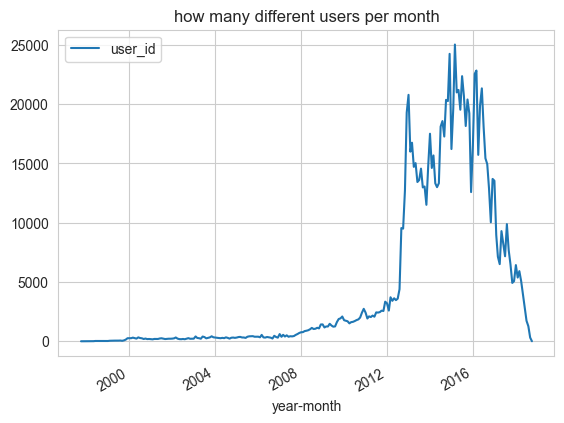

In [14]:
d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().plot(title='how many different users per month');

# how many interactions per month

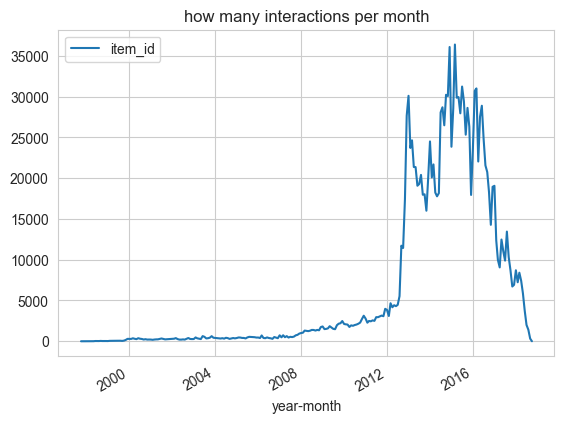

In [15]:
d[[item_col, 'year-month']]\
        .groupby('year-month')\
            .count().plot(title='how many interactions per month');

# how many months have more than 10k users?

In [16]:
(d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count() >= 10000).value_counts()

user_id
False      198
True        51
dtype: int64

# how many months in a year have more than 10k users?

In [17]:
_ = d[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby('year-month')\
            .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 10000, 'year-month'].to_list() 

data_clean.loc[data_clean['year-month'].isin(ym_list),['year', 'year-month']].drop_duplicates().groupby('year').count()


,year-month
year,
2012,2
2013,12
2014,12
2015,12
2016,12
2017,1


years 2013 till 2017 are good to use

# how many interactions in 2012 Dec

(                user_id     item_id  rating year-month       date
 847109   A14XY6XHL3EXRB  B001CMNGJ2     5.0 2012-12-01 2012-12-01
 62334    A1DAKAKS4R02IM  B00136JGZU     5.0 2012-12-01 2012-12-01
 280967   A1C7FT12YICN0J  B007MU87KG     5.0 2012-12-01 2012-12-01
 803196   A2FXW2MEP7TBUI  B0013G1WQG     5.0 2012-12-01 2012-12-01
 1172335   ACV0IFO84L9TJ  B00A9OJWH4     3.0 2012-12-01 2012-12-01
 ...                 ...         ...     ...        ...        ...
 284404   A1HH27E0J7AZGA  B007ZMC3UG     5.0 2013-01-01 2013-01-31
 268072   A37HUQ6I3QNZDW  B006CLTGFQ     5.0 2013-01-01 2013-01-31
 967430    A4WZ5Q9RLJYL0  B003I3MSY2     5.0 2013-01-01 2013-01-31
 1110853  A2AIMXT9PLAM12  B0077GQ6BC     4.0 2013-01-01 2013-01-31
 823635   A3H8GFL4IOR5JR  B0018AKBPA     5.0 2013-01-01 2013-01-31
 
 [57748 rows x 5 columns],
 [('2012-12', '%Y-%m'), ('2013-02', '%Y-%m')],
 '2012-12',
 '2013-02')

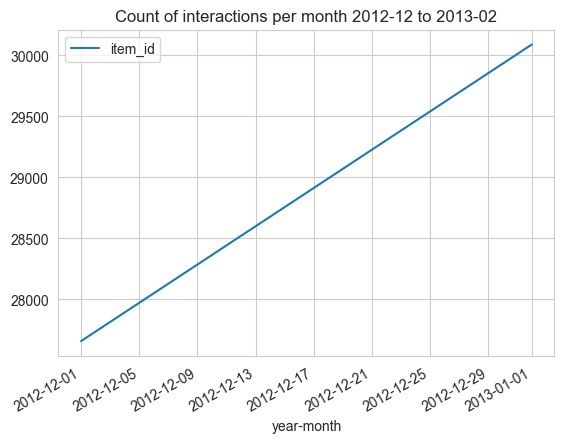

In [18]:
sample_time_period(['2012-12','2013-02'], d, col=item_col)

2013 Dec can be month 0 to pre-train the model

# how many users have full year activity between 2013 and 2016?

In [19]:
_ = data_clean[[user_col, 'year-month', 'year']]\
    .drop_duplicates()\
        .groupby([user_col, 'year'])\
            .count().reset_index()
_.columns = [user_col, 'year', 'months_count']
_

,user_id,year,months_count
0,A00041408PB8URN3FSQ6,2015,1
1,A0009988MRFQ3TROTQPI,2013,1
2,A0009988MRFQ3TROTQPI,2014,1
3,A0015420M7GRKSKTW32Z,2013,1
4,A0025284EDB2S5Q3G9PD,2015,1
...,...,...,...
1008688,AZZYJS5C53MVH,2016,1
1008689,AZZYJS5C53MVH,2018,1
1008690,AZZYKX2KZ0Q82,2013,1
1008691,AZZZ8WQXF8334,2015,1


In [20]:
# list of users with almost full year activity
p = 0.8
user_list = list(set(_.loc[ _['months_count']>= round(12*p), user_col]))

data_clean.loc[data_clean[user_col].isin(user_list), ['year', user_col]]\
            .drop_duplicates()\
                .groupby('year')\
                    .count()

,user_id
year,
2000,4
2001,4
2002,4
2003,3
2004,7
2005,13
2006,17
2007,24
2008,27


2014 has 113 users with almost one full year activity (throughout their entire activity)

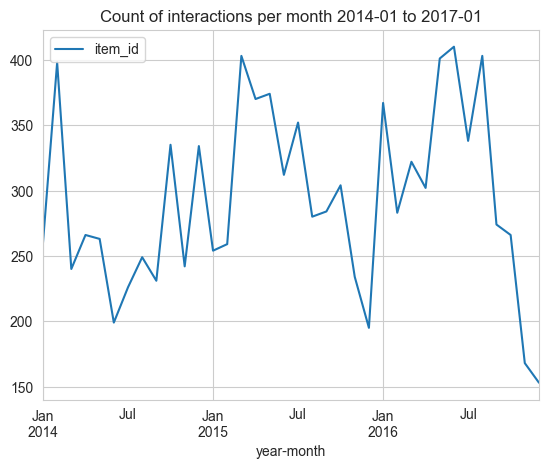

In [21]:
d_fyu_2014 = data_clean.loc[data_clean[user_col].isin(user_list)]
d_fyu_2014, _, _ ,_ = sample_time_period(['2014-01','2017-01'], d_fyu_2014, col=item_col)

In [22]:
print(d_fyu_2014[user_col].nunique())

_ = d_fyu_2014[[user_col, 'year-month']]\
    .drop_duplicates()\
        .groupby([user_col])\
            .count().reset_index()
_.columns = [user_col, 'months_count']
_['three_years_percent'] = _['months_count']/(12*3)
_

128


,user_id,months_count,three_years_percent
0,A119Q9NFGVOEJZ,12,0.333333
1,A11YRHINAJNUQJ,17,0.472222
2,A14GK0E64J0WAS,35,0.972222
3,A14YTPQDH3PAZU,26,0.722222
4,A15JTJXQXO22JJ,24,0.666667
...,...,...,...
123,AVKHYC2D7MD56,21,0.583333
124,AVV5JGLBZERCM,25,0.694444
125,AXBCHD4VWC1BS,7,0.194444
126,AXFNC11IE5NYW,20,0.555556


what if we sample the time period first?

In [62]:
def full_year_activity_users(year, p, df, col):
    data, _, _ ,_ = sample_time_period(year, df, col=col)

    _ = data[[user_col, 'year-month', 'year']]\
        .drop_duplicates()\
            .groupby([user_col, 'year'])\
                .count().reset_index()
    _.columns = [user_col, 'year', 'months_count']
    
    # list of users with almost full year activity
    n_months = 12*_['year'].nunique()
    user_list = list(set(_.loc[ _['months_count']>= round(n_months*p), user_col]))

    print('number of users active in '+str(p*100)+'% of:')
    _ = data.loc[data[user_col].isin(user_list),:]
    print(_.loc[:, ['year', user_col]]\
                .drop_duplicates()\
                    .groupby('year')\
                        .count())

    _.loc[:,[item_col, 'year-month']]\
        .groupby('year-month')\
            .count().plot(title='how many interactions per month');

    print('\nthere are a total of '+str(_.shape[0])+' interactions')

number of users active in 80.0% of:
      user_id
year         
2014       44

there are a total of 2157 interactions


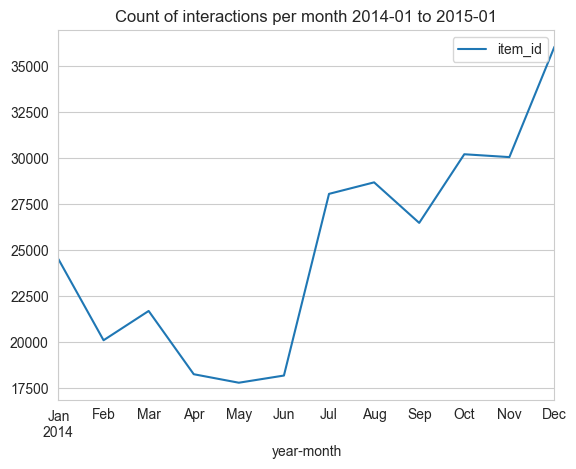

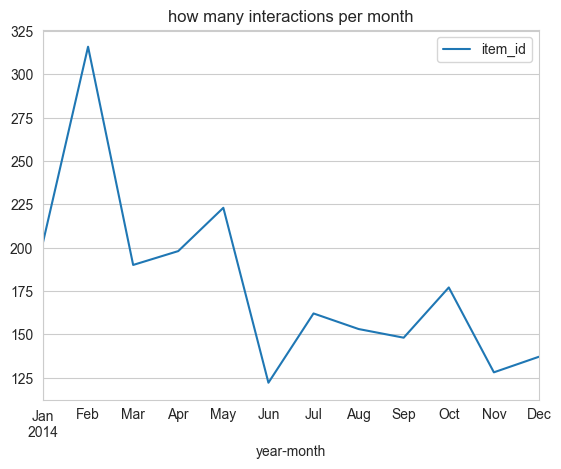

In [63]:
full_year_activity_users(['2014-01','2015-01'], 0.8, data_clean, item_col)

number of users active in 80.0% of:
      user_id
year         
2015       46

there are a total of 2685 interactions


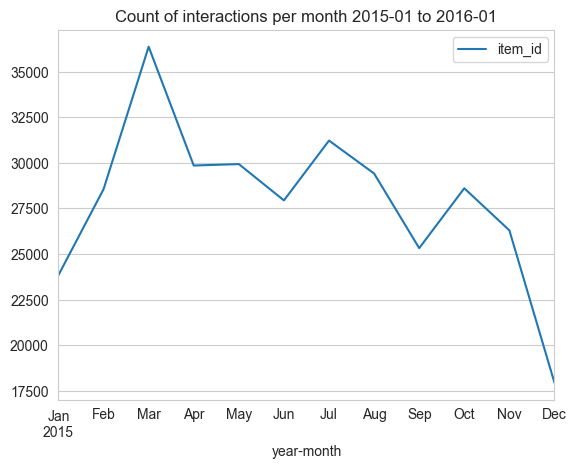

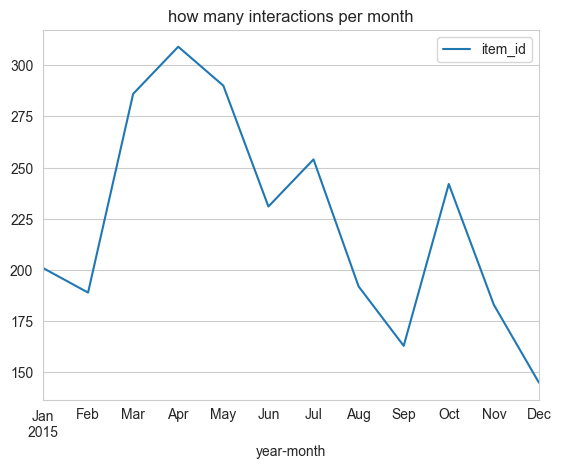

In [64]:
full_year_activity_users(['2015-01','2016-01'], 0.8, data_clean, item_col)

number of users active in 80.0% of:
      user_id
year         
2016       43

there are a total of 2749 interactions


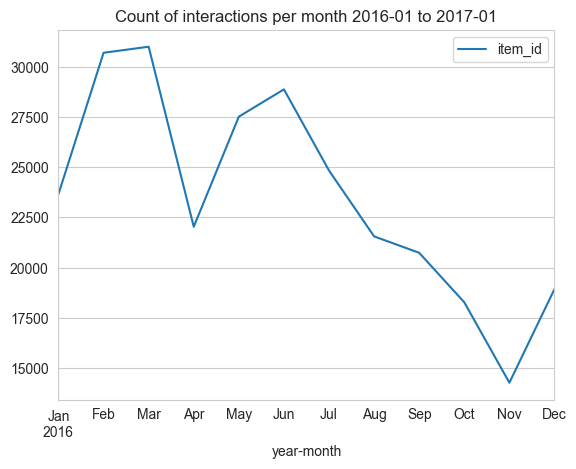

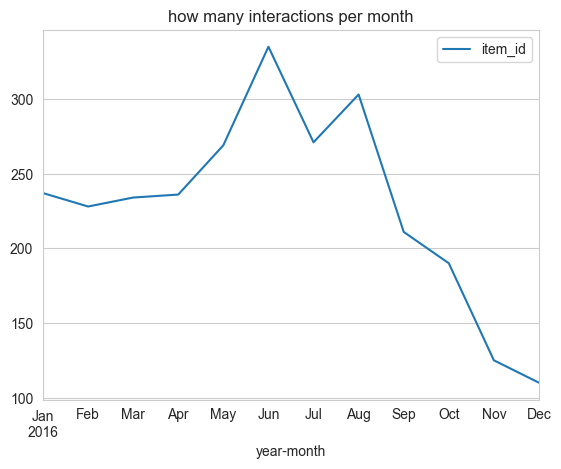

In [65]:
full_year_activity_users(['2016-01','2017-01'], 0.8, data_clean, item_col)

number of users active in 33.33333333333333% of:
      user_id
year         
2014     1592

there are a total of 21072 interactions


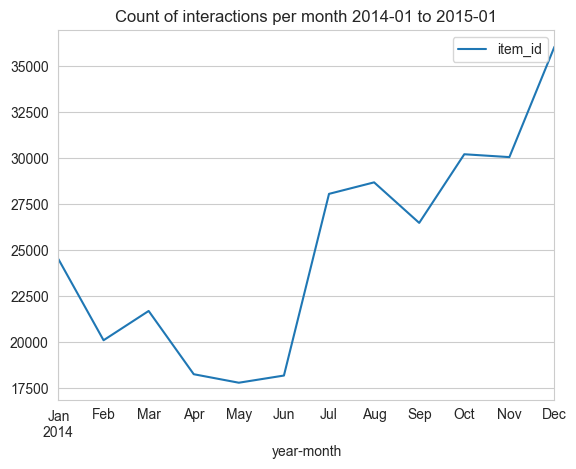

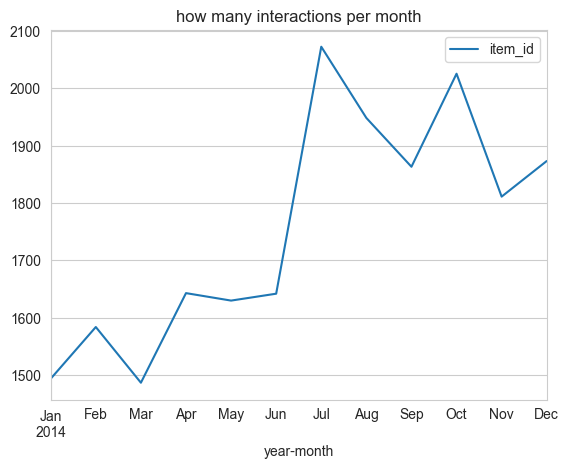

In [67]:
full_year_activity_users(['2014-01','2015-01'], 4/12, data_clean, item_col) # roughly quarter stats

# get user interactions info

In [68]:
dc_2012, _, _, _ = sample_time_period(['2012-12','2017-01'], data_clean, col=item_col)

user_presence_df, user_month_interactions, \
    trimestres, user_trimestre_interactions, \
        semestres, user_semestre_interactions = get_interactions_info(dc_2012, user_col, quarter_info=True, semester_info=True)

0.0 %
5.0 %


In [ ]:
# sample = 'sample_2012-12_until_2017-01'

joblib.dump(user_presence_df, output_path+sample+'_user_presence_df.joblib')
joblib.dump(user_month_interactions, output_path+sample+'_user_month_interactions.joblib')
joblib.dump(trimestres, output_path+sample+'_trimestres.joblib')
joblib.dump(user_trimestre_interactions, output_path+sample+'_user_trimestre_interactions.joblib')
joblib.dump(semestres, output_path+sample+'_semestres.joblib')
joblib.dump(user_semestre_interactions, output_path+sample+'_user_semestre_interactions.joblib')

thr=0.8
frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
joblib.dump(frequent_users, output_path+sample+'_frequent_users_'+str(thr)+'.joblib')


# relaxing the user-presence criteria

In [15]:
user_presence_df = joblib.load(output_path+sample+'_user_presence_df.joblib')
user_presence_df

,UserID,month_%,trimestre_%,semestre_%
0,A3W4D8XOGLWUN5,0.434987,1.000000,1.000000
1,AQ4B80F0JSBNI,0.211796,0.823529,0.777778
2,A70WPHE33U5B,0.154826,0.941176,0.888889
3,A36EDWL4F3AASU,0.143432,0.941176,0.888889
4,A1GGOC9PVDXW7Z,0.140751,0.823529,0.888889
...,...,...,...,...
640181,A91YRJZ3881WS,0.000670,0.058824,0.111111
640182,A18NLL38892PTW,0.000670,0.058824,0.111111
640183,A11BHF2G2G8UDW,0.000670,0.058824,0.111111
640184,A2EZ3X2VZ3POO9,0.000670,0.058824,0.111111


In [16]:
user_month_interactions = joblib.load(output_path+sample+'_user_month_interactions.joblib')
user_month_interactions

,user_id,date,count
19619,A130UE5WLT75P4,2012-12-01,1
428128,A2UG34Q07JU927,2012-12-01,2
529149,A3A36201567K7N,2012-12-01,2
636406,A3QQBF5U5L080I,2012-12-01,1
209282,A1WCWPTPLZLP5,2012-12-01,1
...,...,...,...
841098,AU9TOHN175HIC,2016-12-31,1
103004,A1FYK61JS0LRRZ,2016-12-31,2
763593,AI4HCJJDFZ8IW,2016-12-31,1
415459,A2SIICHSD277AA,2016-12-31,1


In [17]:
trimestres = joblib.load(output_path+sample+'_trimestres.joblib')
trimestres

[(Timestamp('2012-12-01 00:00:00'),
  Timestamp('2013-02-28 00:00:00', freq='3M')),
 (Timestamp('2013-03-01 00:00:00'),
  Timestamp('2013-05-31 00:00:00', freq='3M')),
 (Timestamp('2013-06-01 00:00:00'),
  Timestamp('2013-08-31 00:00:00', freq='3M')),
 (Timestamp('2013-09-01 00:00:00'),
  Timestamp('2013-11-30 00:00:00', freq='3M')),
 (Timestamp('2013-12-01 00:00:00'),
  Timestamp('2014-02-28 00:00:00', freq='3M')),
 (Timestamp('2014-03-01 00:00:00'),
  Timestamp('2014-05-31 00:00:00', freq='3M')),
 (Timestamp('2014-06-01 00:00:00'),
  Timestamp('2014-08-31 00:00:00', freq='3M')),
 (Timestamp('2014-09-01 00:00:00'),
  Timestamp('2014-11-30 00:00:00', freq='3M')),
 (Timestamp('2014-12-01 00:00:00'),
  Timestamp('2015-02-28 00:00:00', freq='3M')),
 (Timestamp('2015-03-01 00:00:00'),
  Timestamp('2015-05-31 00:00:00', freq='3M')),
 (Timestamp('2015-06-01 00:00:00'),
  Timestamp('2015-08-31 00:00:00', freq='3M')),
 (Timestamp('2015-09-01 00:00:00'),
  Timestamp('2015-11-30 00:00:00', freq=

In [18]:
user_trimestre_interactions = joblib.load(output_path+sample+'_user_trimestre_interactions.joblib')
user_trimestre_interactions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
A130UE5WLT75P4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2UG34Q07JU927,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
A3A36201567K7N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3QQBF5U5L080I,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1WCWPTPLZLP5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMOB4CFHX2ZBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A179KDB52PRP23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AU9TOHN175HIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A1FYK61JS0LRRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
thr=0.333
frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
# joblib.dump(frequent_users, output_path+sample+'_frequent_users_'+str(thr)+'.joblib')

1 users of 640186 (0.0%) occurr in 33.300000000000004% or more months.
3851 users of 640186 (0.602%) occurr in 33.300000000000004% or more quarters.
26588 users of 640186 (4.153%) occurr in 33.300000000000004% or more semesters.


In [20]:
frequent_users

(array(['A3W4D8XOGLWUN5'], dtype=object),
 array(['A3W4D8XOGLWUN5', 'AQ4B80F0JSBNI', 'A70WPHE33U5B', ...,
        'A3HQA1A25EPELT', 'AP71MOT43BU85', 'A3T9XXL63R5GWH'], dtype=object),
 array(['A3W4D8XOGLWUN5', 'AQ4B80F0JSBNI', 'A70WPHE33U5B', ...,
        'A3LIC3D3OP1KEY', 'A3C9VJ19D9CXS0', 'A4G5H53IPAEDT'], dtype=object))

## relaxing the criteria - trimester wise

In [21]:
def get_trimester_info_with_user_thresh(print_timeperiod, uti, trimesters_idx, n_trimester_thr):
    '''
        user threshold is 1 interaction in at least *n_trimester_thr* trimestres
    '''

    uti_sample = uti.loc[:,trimesters_idx]

    # trimester-frequent-users of print_timeperiod, with presence in n_trimester_thr
    tfu_filter = (uti_sample>=1).T.sum() >= n_trimester_thr

    futi_sample = uti_sample[tfu_filter]

    print(str(futi_sample.shape[0])+' users of '+str(uti_sample.shape[0])+' ('+str((futi_sample.shape[0]/ uti_sample.shape[0])*100)+'%) in '+str((n_trimester_thr/futi_sample.shape[1])*100)+'% or more trimesters in '+str(print_timeperiod)+' ('+str(futi_sample.sum().sum())+' interactions)')

    print('\nNumber of interactions per trimester in '+str(print_timeperiod)+':\n',futi_sample.sum())

    return futi_sample

In [22]:
trimestre_fu = frequent_users[1]
semestre_fu = frequent_users[2]
tfu_filter = user_trimestre_interactions.index.isin(trimestre_fu)
sfu_filter = user_trimestre_interactions.index.isin(semestre_fu)

print('Warning: these frequent users threshold is 1 year out of the 3 years sample of the data set.\nIt does not guarantee that 1 year of interactions belongs withing the same year\n')
print('number of interactions in each trimestre of trimestre-frequent-users:\n', user_trimestre_interactions[tfu_filter].sum())#/len(semestre_fu))
print('')
print('number of interactions in each trimestre of semestre-frequent-users:\n', user_trimestre_interactions[sfu_filter].sum())#/len(semestre_fu))


It does not guarantee that 1 year of interactions belongs withing the same year

number of interactions in each trimestre of trimestre-frequent-users:
 0     2385.0
1     2577.0
2     2612.0
3     2666.0
4     3050.0
5     3083.0
6     3325.0
7     3554.0
8     3257.0
9     4026.0
10    3862.0
11    3500.0
12    2946.0
13    3326.0
14    3122.0
15    2376.0
16     825.0
dtype: float64

number of interactions in each trimestre of semestre-frequent-users:
 0      7362.0
1      7589.0
2      7506.0
3      7352.0
4      8781.0
5      8635.0
6      9623.0
7     10436.0
8      9822.0
9     12280.0
10    11352.0
11    10198.0
12     8641.0
13     9752.0
14     9271.0
15     6585.0
16     2576.0
dtype: float64


In [12]:
trimestres[8:12] # 8, 9, 10 and 11th trimestres (the ones with higest number of interactions)

[(Timestamp('2014-12-01 00:00:00'),
  Timestamp('2015-02-28 00:00:00', freq='3M')),
 (Timestamp('2015-03-01 00:00:00'),
  Timestamp('2015-05-31 00:00:00', freq='3M')),
 (Timestamp('2015-06-01 00:00:00'),
  Timestamp('2015-08-31 00:00:00', freq='3M')),
 (Timestamp('2015-09-01 00:00:00'),
  Timestamp('2015-11-30 00:00:00', freq='3M'))]

the year 2015 has more interactions

Now i need to fecth the frequent users of 2015 and check if they are enough

In [46]:
get_trimester_info_with_user_thresh(print_timeperiod='2015',
                                    uti=user_trimestre_interactions,
                                    trimesters_idx=[8,9,10,11],
                                    n_trimester_thr=3)

3075 users of 640186 (0.48032915433952006%) in 75.0% or more trimesters in 2015 (16774.0 interactions)

Number of interactions per trimester in 2015:
 8     3653.0
9     4799.0
10    4543.0
11    3779.0
dtype: float64


,8,9,10,11
A2UG34Q07JU927,1.0,1.0,1.0,0.0
A18LYA95666ABF,7.0,0.0,1.0,19.0
A1MTD60X5H0MPN,3.0,1.0,1.0,0.0
A2CA8W5VZSPYY2,1.0,3.0,0.0,1.0
A5R336VHUTPQR,4.0,3.0,1.0,1.0
...,...,...,...,...
A2XVPCGWI1BWVY,0.0,1.0,1.0,1.0
A2ZPAVDWYC2U5A,0.0,1.0,1.0,1.0
AQF493J3Z2J3G,0.0,1.0,1.0,1.0
AN92D6U0K62M1,0.0,1.0,1.0,1.0


In [47]:
# trimestre-frequent-users 2015 with presence in at least 2 quarters 
get_trimester_info_with_user_thresh(print_timeperiod='2015',
                                    uti=user_trimestre_interactions,
                                    trimesters_idx=[8,9,10,11],
                                    n_trimester_thr=2)

18293 users of 640186 (2.8574508033602735%) in 50.0% or more trimesters in 2015 (52774.0 interactions)

Number of interactions per trimester in 2015:
 8     11395.0
9     15142.0
10    14292.0
11    11945.0
dtype: float64


,8,9,10,11
A2UG34Q07JU927,1.0,1.0,1.0,0.0
A18LYA95666ABF,7.0,0.0,1.0,19.0
A3QFB89VTEOS97,1.0,0.0,3.0,0.0
AAQJX54Y1N7BL,1.0,0.0,0.0,1.0
A1MTD60X5H0MPN,3.0,1.0,1.0,0.0
...,...,...,...,...
A38ZJLSE2450RN,0.0,0.0,1.0,1.0
A39OGQMV0J07AV,0.0,0.0,1.0,1.0
A2IECL9PSOZZ1O,0.0,0.0,1.0,1.0
A3H3OLYSDWHP3S,0.0,0.0,1.0,1.0


## relaxing the criteria - semester wise

In [21]:
def get_semester_info_with_user_thresh(print_timeperiod:str, usi:pd.DataFrame, semesters_idx:int, n_semester_thr:int):
    '''
        user threshold is 1 interaction in at least *n_semester_thr* semesters
    '''

    usi_sample = usi.loc[:,semesters_idx]

    # semester-frequent-users, presence in all semesters
    sfu_filter = (usi_sample>0).T.sum() >= n_semester_thr
    # in doubt? run:
    #         print((pd.Series([1, 1, 0])>0))
    #         print(pd.Series([True, True, False]).sum())
    #         print((pd.Series([1, 1, 0])>0).sum())
    #         print((pd.Series([1, 1, 0])>0).sum()>=2)

    fusi_sample = usi_sample[sfu_filter]

    print(str(fusi_sample.shape[0])+' users of '+str(usi_sample.shape[0])+' ('+str((fusi_sample.shape[0]/ usi_sample.shape[0])*100)+'%) in '+str((n_semester_thr/fusi_sample.shape[1])*100)+'% or more semesters in '+str(print_timeperiod)+' ('+str(fusi_sample.sum().sum())+' interactions)')

    print('\nNumber of interactions per semester in '+str(print_timeperiod)+':\n',fusi_sample.sum())

    return fusi_sample


In [22]:
semesters = joblib.load(output_path+sample+'_semestres.joblib')

user_semester_interactions = joblib.load(output_path+sample+'_user_semestre_interactions.joblib')


trimestre_fu = frequent_users[1]
semestre_fu = frequent_users[2]
tfu_filter = user_semester_interactions.index.isin(trimestre_fu)
sfu_filter = user_semester_interactions.index.isin(semestre_fu)

print('Warning: these frequent users threshold is 1 year out of the 3 years sample of the data set.\nIt does not guarantee that 1 year of interactions belongs withing the same year\n')
print('number of interactions in each semester of trimestre-frequent-users:\n', user_semester_interactions[tfu_filter].sum())#/len(semestre_fu))
print('')
print('number of interactions in each semester of semestre-frequent-users:\n', user_semester_interactions[sfu_filter].sum())#/len(semestre_fu))


It does not guarantee that 1 year of interactions belongs withing the same year

number of interactions in each semester of trimestre-frequent-users:
 0    4962.0
1    5278.0
2    6133.0
3    6879.0
4    7283.0
5    7362.0
6    6272.0
7    5498.0
8     825.0
dtype: float64

number of interactions in each semester of semestre-frequent-users:
 0    14951.0
1    14858.0
2    17416.0
3    20059.0
4    22102.0
5    21550.0
6    18393.0
7    15856.0
8     2576.0
dtype: float64


In [26]:
semesters[4:6] # 4th and 5th semestres (the ones with higest number of interactions)

[(Timestamp('2014-12-01 00:00:00'),
  Timestamp('2015-05-31 00:00:00', freq='6M')),
 (Timestamp('2015-06-01 00:00:00'),
  Timestamp('2015-11-30 00:00:00', freq='6M'))]

In [49]:
# semester-frequent-users 2015 with presence in all semester
get_semester_info_with_user_thresh(print_timeperiod='2015',
                                   usi=user_semester_interactions,
                                   semesters_idx=[4,5],
                                   n_semester_thr=2)

12268 users of 640186 (1.9163180700608886%) in 100.0% or more semesters in 2015 (38122.0 interactions)

Number of interactions per semester in 2015:
 4    19221.0
5    18901.0
dtype: float64


,4,5
A2UG34Q07JU927,2.0,1.0
A18LYA95666ABF,7.0,20.0
A3QFB89VTEOS97,1.0,3.0
AAQJX54Y1N7BL,1.0,1.0
A1MTD60X5H0MPN,4.0,1.0
...,...,...
A3DV1QEB9EQCKV,1.0,5.0
A3VN9ZGCFSIWAD,1.0,2.0
AIZS530YGOVGE,1.0,3.0
AL23IKRDD3WCX,1.0,1.0


In [50]:
# semester-frequent-users 2015 with presence in at least 1.25 semester
get_semester_info_with_user_thresh(print_timeperiod='2015',
                                   usi=user_semester_interactions,
                                   semesters_idx=[4,5],
                                   n_semester_thr=1.25)

12268 users of 640186 (1.9163180700608886%) in 62.5% or more semesters in 2015 (38122.0 interactions)

Number of interactions per semester in 2015:
 4    19221.0
5    18901.0
dtype: float64


,4,5
A2UG34Q07JU927,2.0,1.0
A18LYA95666ABF,7.0,20.0
A3QFB89VTEOS97,1.0,3.0
AAQJX54Y1N7BL,1.0,1.0
A1MTD60X5H0MPN,4.0,1.0
...,...,...
A3DV1QEB9EQCKV,1.0,5.0
A3VN9ZGCFSIWAD,1.0,2.0
AIZS530YGOVGE,1.0,3.0
AL23IKRDD3WCX,1.0,1.0


In [37]:
# semester-frequent-users 2015 with presence in at least 1 semester
get_semester_info_with_user_thresh(print_timeperiod='2015',
                                   usi=user_semester_interactions,
                                   semesters_idx=[4,5],
                                   n_semester_thr=1)

214830 users of 214830 (33.557434870490766%) in 50.0% or more semesters in 2015 (258212.0 interactions)

Number of interactions per semester in 2015:
 4    132655.0
5    125557.0
dtype: float64


,4,5
A2UG34Q07JU927,2.0,1.0
A3E98WUE4V5CSJ,2.0,0.0
A2QPJNAQDE1IJW,1.0,0.0
A2XAJX9EOMX969,0.0,1.0
A31K5W6NWK68OA,2.0,0.0
...,...,...
A2O02SFH5YQ6M5,0.0,1.0
A3L41PDLN8S81T,0.0,1.0
A3387XU1VRIARG,0.0,1.0
AWO86HFT5X8TZ,0.0,1.0


In [40]:
get_semester_info_with_user_thresh(print_timeperiod='2014 and 2015',
                                   usi=user_semester_interactions,
                                   semesters_idx=[2,3,4,5],
                                   n_semester_thr=3)

6905 users of 6905 (1.078592783972158%) in 75.0% or more semesters in 2014 and 2015 (40535.0 interactions)

Number of interactions per semester in 2014 and 2015:
 2     8804.0
3    10885.0
4    11001.0
5     9845.0
dtype: float64


,2,3,4,5
A2UG34Q07JU927,1.0,1.0,2.0,1.0
A18LYA95666ABF,2.0,3.0,7.0,20.0
A3CAEO7YMAO1LT,1.0,1.0,0.0,1.0
A3QFB89VTEOS97,1.0,2.0,1.0,3.0
AAQJX54Y1N7BL,1.0,2.0,1.0,1.0
...,...,...,...,...
AGXBLBNE00GWD,0.0,1.0,1.0,1.0
A2VD4C68L00N29,0.0,1.0,1.0,1.0
A1OV41UNIGLVUM,0.0,1.0,4.0,1.0
A2JC5PFGUDHS1N,0.0,1.0,1.0,1.0


In [47]:
frequent_users_2015_16_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2015 and 2016',
                                                                                  usi=user_semester_interactions,
                                                                                  semesters_idx=[4,5,6,7],
                                                                                  n_semester_thr=3)

frequent_users_2015_16_semester_interactions

7368 users of 640186 (1.1509155151784012%) in 75.0% or more semesters in 2015 and 2016 (43394.0 interactions)

Number of interactions per semester in 2015 and 2016:
 4    10677.0
5    12092.0
6    11013.0
7     9612.0
dtype: float64


,4,5,6,7
A31K5W6NWK68OA,2.0,0.0,2.0,3.0
A18LYA95666ABF,7.0,20.0,18.0,10.0
AAQJX54Y1N7BL,1.0,1.0,0.0,1.0
A25J30XBHS2O1O,2.0,3.0,1.0,0.0
A2CA8W5VZSPYY2,4.0,1.0,2.0,2.0
...,...,...,...,...
AUMNGD8U1773T,0.0,1.0,1.0,1.0
AYEP2CVF0D89N,0.0,1.0,3.0,1.0
ATUJL61OYKM1O,0.0,1.0,1.0,1.0
ACK9WMO8SCOEZ,0.0,1.0,2.0,1.0


In [48]:
frequent_users_2015_16 = frequent_users_2015_16_semester_interactions.index.to_list()
frequent_users_2015_16[:5]

['A31K5W6NWK68OA',
 'A18LYA95666ABF',
 'AAQJX54Y1N7BL',
 'A25J30XBHS2O1O',
 'A2CA8W5VZSPYY2']

In [29]:
user_semester_interactions

,0,1,2,3,4,5,6,7,8
A130UE5WLT75P4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2UG34Q07JU927,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0
A3A36201567K7N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3QQBF5U5L080I,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1WCWPTPLZLP5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
AMOB4CFHX2ZBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A179KDB52PRP23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AU9TOHN175HIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A1FYK61JS0LRRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
f = user_semester_interactions.index.isin(frequent_users_2015_16)
cold_start_semester_interactions = user_semester_interactions.loc[f, 3]
cold_start_semester_interactions

A31K5W6NWK68OA    0.0
A18LYA95666ABF    3.0
AAQJX54Y1N7BL     2.0
A25J30XBHS2O1O    2.0
A2CA8W5VZSPYY2    3.0
                 ... 
AUMNGD8U1773T     0.0
AYEP2CVF0D89N     0.0
ATUJL61OYKM1O     0.0
ACK9WMO8SCOEZ     0.0
A3S0RNZZPZ9KCL    0.0
Name: 3, Length: 7368, dtype: float64

In [50]:
frequent_users_2015_16_semester_interactions.insert(0, 3, cold_start_semester_interactions)
frequent_users_2015_16_semester_interactions


,3,4,5,6,7
A31K5W6NWK68OA,0.0,2.0,0.0,2.0,3.0
A18LYA95666ABF,3.0,7.0,20.0,18.0,10.0
AAQJX54Y1N7BL,2.0,1.0,1.0,0.0,1.0
A25J30XBHS2O1O,2.0,2.0,3.0,1.0,0.0
A2CA8W5VZSPYY2,3.0,4.0,1.0,2.0,2.0
...,...,...,...,...,...
AUMNGD8U1773T,0.0,0.0,1.0,1.0,1.0
AYEP2CVF0D89N,0.0,0.0,1.0,3.0,1.0
ATUJL61OYKM1O,0.0,0.0,1.0,1.0,1.0
ACK9WMO8SCOEZ,0.0,0.0,1.0,2.0,1.0


In [51]:
fu_2015_16_semesters = semesters[3:8] # cold start + sample
fu_2015_16_semesters

[(Timestamp('2014-06-01 00:00:00'),
  Timestamp('2014-11-30 00:00:00', freq='6M')),
 (Timestamp('2014-12-01 00:00:00'),
  Timestamp('2015-05-31 00:00:00', freq='6M')),
 (Timestamp('2015-06-01 00:00:00'),
  Timestamp('2015-11-30 00:00:00', freq='6M')),
 (Timestamp('2015-12-01 00:00:00'),
  Timestamp('2016-05-31 00:00:00', freq='6M')),
 (Timestamp('2016-06-01 00:00:00'),
  Timestamp('2016-11-30 00:00:00', freq='6M'))]

In [24]:
# sample_1516 = 'sample_2014-06_until_2016-11+cold_start'
thr = 3/4
sample_fu_1516 = 'fu_'+str(thr)

In [34]:
joblib.dump(fu_2015_16_semesters, output_path+sample_1516+'_'+sample_fu_1516+'_semestres.joblib')
joblib.dump([None, None, frequent_users_2015_16], output_path+sample_1516+'_frequent_users_'+str(thr)+'.joblib')
joblib.dump(frequent_users_2015_16_semester_interactions, output_path+sample_1516+'_'+sample_fu_1516+'_user_semestre_interactions.joblib')

['output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_fu_0.75_user_semestre_interactions.joblib']

In [ ]:
# deprecated

# sample_15 = 'sample_2015-01_until_2016-01'

# dc_2015, _, _, _ = sample_time_period(['2015-01','2016-01'], data_clean, col=item_col)


# user_presence_df, user_month_interactions, \
#     trimestres, user_trimestre_interactions, \
#         semestres, user_semestre_interactions = get_interactions_info(dc_2015, user_col, quarter_info=True, semester_info=True)

# joblib.dump(user_presence_df, output_path+sample_15+'_user_presence_df.joblib')
# joblib.dump(user_month_interactions, output_path+sample_15+'_user_month_interactions.joblib')
# joblib.dump(trimestres, output_path+sample_15+'_trimestres.joblib')
# joblib.dump(user_trimestre_interactions, output_path+sample_15+'_user_trimestre_interactions.joblib')
# joblib.dump(semestres, output_path+sample_15+'_semestres.joblib')
# joblib.dump(user_semestre_interactions, output_path+sample_15+'_user_semestre_interactions.joblib')

# thr=0.8
# frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
# joblib.dump(frequent_users, output_path+sample_15+'_frequent_users_'+str(thr)+'.joblib')

In [25]:
fu_2015_26_semesters = joblib.load(output_path+sample_1516+'_'+sample_fu_1516+'_semestres.joblib')
frequent_users_2015_16 = joblib.load(output_path+sample_1516+'_frequent_users_'+str(thr)+'.joblib')
frequent_users_2015_16_semester_interactions = joblib.load(output_path+sample_1516+'_'+sample_fu_1516+'_user_semestre_interactions.joblib')

In [26]:
user_semester_interactions

,0,1,2,3,4,5,6,7,8
A130UE5WLT75P4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2UG34Q07JU927,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0
A3A36201567K7N,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3QQBF5U5L080I,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1WCWPTPLZLP5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
AMOB4CFHX2ZBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A179KDB52PRP23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AU9TOHN175HIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
A1FYK61JS0LRRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
len(semesters)

8

In [30]:
get_semester_info_with_user_thresh(print_timeperiod='2014 to 2017',
                                   usi=user_semester_interactions,
                                   semesters_idx=[3,4,5,6,7,8],
                                   n_semester_thr=5)

1016 users of 640186 (0.15870387668583819%) in 83.33333333333334% or more semesters in 2014 to 2017 (15361.0 interactions)

Number of interactions per semester in 2014 to 2017:
 3    2641.0
4    3067.0
5    3343.0
6    2998.0
7    2779.0
8     533.0
dtype: float64


,3,4,5,6,7,8
A18LYA95666ABF,3.0,7.0,20.0,18.0,10.0,5.0
A2CA8W5VZSPYY2,3.0,4.0,1.0,2.0,2.0,0.0
A1IWWRZJOXOSYP,11.0,11.0,8.0,7.0,7.0,0.0
A3L9FT8OJY4Q6I,2.0,4.0,7.0,4.0,3.0,0.0
ASEBX8TBYWQWA,6.0,4.0,8.0,5.0,7.0,0.0
...,...,...,...,...,...,...
A35UMI5X0IA94M,0.0,3.0,1.0,1.0,3.0,1.0
APW0MJTWVR2BD,0.0,1.0,1.0,3.0,2.0,2.0
A3TRSQT9FEWWVT,0.0,1.0,6.0,2.0,4.0,1.0
A2YECX5S65MH91,0.0,1.0,6.0,6.0,1.0,1.0


# filter data clean

In [28]:
fu_2015_26_semesters[-1][1]

Timestamp('2016-11-30 00:00:00', freq='6M')

In [33]:
date_fu_filter = (fu_2015_26_semesters[0][0] <= data_clean['date']) & (data_clean['date'] < fu_2015_26_semesters[-1][1]) &\
                    (data_clean[user_col].isin(frequent_users_2015_16[2]))
                 
data = data_clean.loc[date_fu_filter, [user_col, item_col, rate_col, time_col, 'date']] # frequent_users_2015_16
data

,user_id,item_id,rating,timestamp,date
1069932,A1G1PWJWIVW6UR,B005OFVNTS,4.0,1401580800,2014-06-01
930018,AQ4B80F0JSBNI,B002B8ZS0Q,5.0,1401580800,2014-06-01
214758,A3GYWZE27QBMY7,B003RO1N98,5.0,1401580800,2014-06-01
630121,A2HXYN2R7W1UQW,B000NNB2PG,5.0,1401580800,2014-06-01
630075,APKXB8GFNRKEF,B000AOAA74,5.0,1401580800,2014-06-01
...,...,...,...,...,...
1212653,A1PRFQEIVYSWV3,B00C15V4M0,5.0,1480377600,2016-11-29
798694,A297W40NNZ4S64,B0013AS1AC,5.0,1480377600,2016-11-29
1164426,A1PRFQEIVYSWV3,B009Y4E4U0,5.0,1480377600,2016-11-29
772773,A1PRFQEIVYSWV3,B00137IP4C,5.0,1480377600,2016-11-29


In [34]:
data[rate_col].value_counts()

5.0    68065
4.0    12595
3.0     3551
1.0     1093
2.0      999
Name: rating, dtype: int64

In [35]:
data[[user_col, rate_col]].drop_duplicates().groupby(rate_col).count()

,user_id
rating,
1.0,582
2.0,573
3.0,1484
4.0,3147
5.0,7238


The previous data requiremnts are tight already. I think there are too many low rates to be able to connsider only the 5* rates. So, the implicit feedback data will interpret data as "has rated". All will be fed to the model.

In [38]:
data[[user_col, item_col, time_col, 'date']].to_csv(output_path+sample_1516+'_amazon_digitalmusic.csv', index=False)

In [45]:
data_pos_rates = data.loc[data[rate_col]>3,:]
data_pos_rates

,user_id,item_id,rating,timestamp,date
1069932,A1G1PWJWIVW6UR,B005OFVNTS,4.0,1401580800,2014-06-01
930018,AQ4B80F0JSBNI,B002B8ZS0Q,5.0,1401580800,2014-06-01
214758,A3GYWZE27QBMY7,B003RO1N98,5.0,1401580800,2014-06-01
630121,A2HXYN2R7W1UQW,B000NNB2PG,5.0,1401580800,2014-06-01
630075,APKXB8GFNRKEF,B000AOAA74,5.0,1401580800,2014-06-01
...,...,...,...,...,...
1212653,A1PRFQEIVYSWV3,B00C15V4M0,5.0,1480377600,2016-11-29
798694,A297W40NNZ4S64,B0013AS1AC,5.0,1480377600,2016-11-29
1164426,A1PRFQEIVYSWV3,B009Y4E4U0,5.0,1480377600,2016-11-29
772773,A1PRFQEIVYSWV3,B00137IP4C,5.0,1480377600,2016-11-29


In [59]:
print(data_pos_rates['user_id'].nunique())
print(len(frequent_users_2015_16[2]))
frequent_users_2015_16_pos_rates = list(set(data_pos_rates['user_id'].unique()) & set(frequent_users_2015_16[2]))
print(len(frequent_users_2015_16_pos_rates))

7353
7368
7353


In [60]:
data_pos_rates[[user_col, item_col, time_col, 'date']].to_csv(output_path+sample_1516+'_positive_rates'+'_amazon_digitalmusic.csv', index=False)
joblib.dump([None, None, frequent_users_2015_16_pos_rates], output_path+sample_1516+'_positive_rates'+'_frequent_users_'+str(thr)+'.joblib')

['output/amazon_digmusic_dump/sample_2014-06_until_2016-11+cold_start_positive_rates_frequent_users_0.75.joblib']

# Meta Data

In [3]:
meta_dm = getDF('../datasets/meta_Digital_Music.json.gz')
'''
where

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table
'''

meta_dm.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,Master Collection Volume One,"[B000002UEN, B000008LD5, B01J804JKE, 747403435...",,John Michael Talbot,[],"58,291 in CDs & Vinyl (","[B000002UEN, B000008LD5, 7474034352, B000008LD...","<img src=""https://images-na.ssl-images-amazon....",,,$18.99,0001377647,[],[],NaN
1,[],,[],,Hymns Collection: Hymns 1 &amp; 2,"[5558154950, B00014K5V4]",,Second Chapter of Acts,[],"93,164 in CDs & Vinyl (","[B000008KJ3, B000008KJ0, 5558154950, B000UN8KZ...","<img src=""https://images-na.ssl-images-amazon....",,,,0001529145,[],[],NaN
2,[],,[],,Early Works - Don Francisco,"[B00004RC05, B003H8F4NA, B003ZFVHPO, B003JMP1Z...",,Don Francisco,[],"875,825 in CDs & Vinyl (","[B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00004RC0...","<img src=""https://images-na.ssl-images-amazon....",,,,0001527134,[],[],NaN
3,[],,[],,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2G...",,Keith Green,[],"203,263 in CDs & Vinyl (","[B00000I7JO, B0016CP2GS, 0001393774, B0000275Q...","<img src=""https://images-na.ssl-images-amazon....",,,$13.01,0001388703,[],[],NaN
4,[],,[1. Losing Game 2. I Can't Wait 3. Didn't He S...,,Early Works - Dallas Holm,"[B0002N4JP2, 0760131694, B00002EQ79, B00150K8J...",,Dallas Holm,[],"399,269 in CDs & Vinyl (","[B0002N4JP2, 0760131694, B00150K8JC, B003MTXNV...","<img src=""https://images-na.ssl-images-amazon....",,,,0001526146,[],[],NaN


In [4]:
def get_filter_presence_in_column(df, col):
    return df.apply(lambda x: x[col]!=[], axis=1)

def get_presence_in_column(df, col):
    return get_filter_presence_in_column(df, col).value_counts()/df.shape[0]

In [5]:
print('true -> there is a value\nfalse -> empty')
print('\n'+'category'+'\n', get_presence_in_column(meta_dm, 'category'))
print('\n'+'description'+'\n', get_presence_in_column(meta_dm, 'description'))
print('\n'+'feature'+'\n', get_presence_in_column(meta_dm, 'feature'))
print('\n'+'rank'+'\n', get_presence_in_column(meta_dm, 'rank'))
print('\n'+'brand'+'\n', get_presence_in_column(meta_dm, 'brand'))


true -> there is a value
false -> empty

category
 False    0.999906
True     0.000094
dtype: float64

description
 False    0.508709
True     0.491291
dtype: float64

feature
 False    0.998803
True     0.001197
dtype: float64

rank
 True     0.920131
False    0.079869
dtype: float64

brand
 True    1.0
dtype: float64


we could use rank and brand

In [51]:
df = meta_dm.loc[get_filter_presence_in_column(meta_dm, 'rank'), ['asin','brand', 'rank']]
df

,asin,brand,rank
0,0001377647,John Michael Talbot,"58,291 in CDs & Vinyl ("
1,0001529145,Second Chapter of Acts,"93,164 in CDs & Vinyl ("
2,0001527134,Don Francisco,"875,825 in CDs & Vinyl ("
3,0001388703,Keith Green,"203,263 in CDs & Vinyl ("
4,0001526146,Dallas Holm,"399,269 in CDs & Vinyl ("
...,...,...,...
74339,B01HH68B96,THE OUTLAWS,"325,681 in CDs & Vinyl ("
74342,B01HH7D5KU,FUTURE,"695,581 in CDs & Vinyl ("
74343,B01HHGQXI2,Tori Amos,"1,577,399 in CDs & Vinyl ("
74344,B01HHRIKKK,EXO,"130,165 in CDs & Vinyl ("


In [52]:
df.brand.value_counts()

                                       12221
Various Artists                         1126
Various                                  693
VARIOUS ARTISTS                          245
various                                  119
                                       ...  
Poluzjanci                                 1
Ernest Tubb & The Texas Troubadours        1
Sonic Flood                                1
House Project                              1
Bridge/Britten                             1
Name: brand, Length: 33963, dtype: int64

In [54]:
df.loc[(df.brand=='Various') | (df.brand=='VARIOUS ARTISTS') |\
       (df.brand=='various') | (df.brand=='VARIOUS') | (df.brand=='V.A.'), 'brand'] = 'Various Artists'
df = df[(df.brand != '')]
# df = df[(df.brand != '\n')]
df.brand.value_counts()

Various Artists              2351
Elvis Presley                 105
The Beatles                   103
\n                             93
Wolfgang Amadeus Mozart        69
                             ... 
Sonic Flood                     1
House Project                   1
CUBISMO GRAFICO                 1
K2 Groove                       1
JERRY MURAD'S HARMONICATS       1
Name: brand, Length: 33957, dtype: int64

In [61]:
print('how many items have x amount of brands:\n',df[['asin', 'brand']].groupby('asin').count().value_counts())#.value_counts()

how many items have x amount of brands:
 brand
1        42278
2         6955
dtype: int64


In [26]:
_ = df[['asin', 'brand']].groupby('asin').count()
df[df.asin.isin((_[ _.brand>1 ]).index)]

,asin,brand,rank
1953,B00000I8DB,Richard Wagner,"717,489 in CDs &amp; Vinyl ("
1954,B00000I8FQ,Billy Mac,"590,755 in CDs & Vinyl ("
1955,B00000I8D7,Berthe Monmart,"283,046 in CDs & Vinyl ("
1956,B00000I8D0,Mozart,"1,666,222 in CDs & Vinyl ("
1957,B00000I8I5,Michael Monsalve,"2,936,062 in CDs & Vinyl ("
...,...,...,...
18616,B0005ME08Q,Patti LaBelle,"828,535 in CDs & Vinyl ("
18617,B0005UI3PO,Chris Hawkey,"1,126,407 in CDs & Vinyl ("
18618,B0005PUY6U,Peregrine Way,"2,991,822 in CDs &amp; Vinyl ("
18619,B00059R7AM,The Temporary Thing,"824,786 in CDs &amp; Vinyl ("


In [62]:
df.brand.value_counts()>1

Various Artists               True
Elvis Presley                 True
The Beatles                   True
\n                            True
Wolfgang Amadeus Mozart       True
                             ...  
Sonic Flood                  False
House Project                False
CUBISMO GRAFICO              False
K2 Groove                    False
JERRY MURAD'S HARMONICATS    False
Name: brand, Length: 33957, dtype: bool

# code to be re-used from now on

## how many users have more than k-interactions per month?

In [ ]:
(d[[user_col, 'year-month']]\
        .value_counts() > 5).value_counts()

## get k-core/month users

In [ ]:
k = 4
user_interactions_per_month = d[[user_col, 'year-month']]\
                                        .value_counts().to_frame('interactions_per_month').reset_index()
users_kcore_month_list = user_interactions_per_month.loc[user_interactions_per_month['interactions_per_month']>k, user_col].to_list()
users_kcore_month_list[:10]

## k-core/month-users' interactions per month

In [ ]:
dc_kcore_filter = data_clean[user_col].isin(users_kcore_month_list)
data_clean.loc[dc_kcore_filter,[user_col, 'year-month']]\
                .groupby('year-month')\
                    .count().plot(title='how many *interactions per month* of '+str(k)+'-core/month-users');

if we bin it per trimestre, each bucket will have more interactions

## how many k-core-users per month?

In [ ]:
data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().plot(title='how many k-core-users per month?');

## how many months in a year have more than 790 k-core/month-users?

In [ ]:
_ = data_clean.loc[dc_kcore_filter, [user_col, 'year-month']]\
            .drop_duplicates()\
                .groupby('year-month')\
                    .count().reset_index()
_.columns = ['year-month', 'users_count']


ym_list = _.loc[ _['users_count']>= 790, 'year-month'].to_list() 

data_clean.loc[dc_kcore_filter &\
               data_clean['year-month'].isin(ym_list), ['year', 'year-month']]\
        .drop_duplicates() \
            .groupby('year').count()

## filter data with time period and k-core/month users

In [ ]:
time_period = [('2013-01', '%Y-%m'), ('2017-01', '%Y-%m')]
data = data_clean[(data_clean['year-month'] >= datetime.strptime(*time_period[0])) & \
                  (data_clean['year-month'] < datetime.strptime(*time_period[1])) &\
                    (data_clean[user_col].isin(users_kcore_month_list))]
data

In [ ]:
print('STAGE -> What is the user presence distribution based on month, quarter, and semester?')
n_days_sample = (datetime.strptime(*time_period[1]) - datetime.strptime(*time_period[0])).days
print('number of days in the time period sampled: ',n_days_sample)

if n_days_sample >= 182:
    user_presence_df, user_month_interactions,\
        trimestres, user_trimestre_interactions,\
        semestres, user_semestre_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=True, 
                                                                        semester_info=True)
elif n_days_sample >= 91:
    user_presence_df, user_month_interactions,\
        trimestres, user_trimestre_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=True, 
                                                                        semester_info=False)
else:
    user_presence_df, user_month_interactions = get_interactions_info(data=data, 
                                                                        user_col=user_col,
                                                                        quarter_info=False, 
                                                                        semester_info=False)

plot_user_presence_distribution(user_presence_df, dataset_name)          

# user_presence_df.to_csv('output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_user_presence_df.csv', index=False)
# user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_user_month_interactions.csv', index=False)


In [ ]:
if n_days_sample >= 91:
    plot_interactions_per_qns(user_interactions=user_trimestre_interactions, 
                            date_range=trimestres, 
                            dataset_name=dataset_name, 
                            type_of_range='quarter')
    # joblib.dump(trimestres, 'output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_trimestres.joblib')

if n_days_sample >= 182:
    plot_interactions_per_qns(user_interactions=user_semestre_interactions, 
                            date_range=semestres,
                            dataset_name=dataset_name,
                            type_of_range='semester')
    # joblib.dump(semestres, 'output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_semestres.joblib')

In [ ]:
user_presence_df.head()

In [ ]:
user_month_interactions.head()

In [ ]:
user_trimestre_interactions.head()

In [ ]:
user_semestre_interactions.head()

In [ ]:
import joblib
sample_str = str(time_period[0][0])+'_until_'+str(time_period[1][0])
user_presence_df.to_csv('output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_user_month_interactions.csv', index=False)
joblib.dump(trimestres, 'output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_trimestres.joblib')
joblib.dump(semestres, 'output/amazon_digmusic_dump/sample_kcore_'+sample_str+'_semestres.joblib')

## get k-core-users/trimestre

In [ ]:
def create_period_column(df, period_col_name, period_timestamps):
    df.loc[:, period_col_name] = 0

    for i, (t_start, t_end) in enumerate(period_timestamps):
        t_filter = (df['year-month'] >= t_start) & \
                    (df['year-month'] < t_end)
        df.loc[t_filter, period_col_name] = i
    return df

def get_k_core_per_period(df, period, period_timestamps=None, k=5, m=1000, user_col='user_id'):
    '''
        df: pd.DataFrame , must have a user_col, 'year' and 'year-month' columns
                        will add period column to frame
        period: str , ['month', 'trimestre', 'semestre']
        period_timestamps: list , list of timestamp
        k: int , minimum number of interactions per period
        m: int , minimum number of k-core-users per period
        user_col: str = 'user_id'
    '''

    if period == 'month':
        period_col_name = 'year-month'

    elif period == 'trimestre':
        period_col_name = 'trimestre_n'
        df = create_period_column(df, period_col_name, period_timestamps)
        
    elif period == 'semestre':
        period_col_name = 'semestre_n'
        df = create_period_column(df, period_col_name, period_timestamps)

    # get user interactions per period
    interactions_col_name = 'interactions_per_'+period

    user_interactions_per_period = data[[user_col, period_col_name]]\
                                            .value_counts().to_frame(interactions_col_name).reset_index()
    users_kcore_period_list = user_interactions_per_period.loc[user_interactions_per_period[interactions_col_name]>=k, user_col].to_list()

    # filter users
    kcore_filter = data[user_col].isin(users_kcore_period_list)
    
    # plot 'how many *interactions per period* of k-core/period-users'
    df.loc[kcore_filter,[user_col, period_col_name]]\
                    .groupby(period_col_name)\
                        .count().plot(title='how many *interactions per '+period+'* of '+str(k)+'-core/'+period+'-users');


    # plot 'how many k-core-users per period?'
    df.loc[kcore_filter,[user_col, period_col_name]]\
        .drop_duplicates()\
            .groupby(period_col_name)\
                .count().plot(title='how many *'+str(k)+'-core/'+period+'-users* per '+period+'?');


    print('Number of periods that have at least '+str(m)+' '+str(k)+'-core/'+period+'-users in each year')
    _ = df.loc[kcore_filter,[user_col, period_col_name]]\
            .drop_duplicates()\
                .groupby(period_col_name)\
                    .count().reset_index()
    _.columns = [period_col_name, 'users_count']

    ym_list = _.loc[ _['users_count']>= m, period_col_name].to_list() 

    print(df.loc[kcore_filter &\
                 df[period_col_name].isin(ym_list), ['year', period_col_name]]\
            .drop_duplicates() \
                .groupby('year').count())
    
    return df, kcore_filter


In [ ]:
len(trimestres)

In [ ]:
data

In [ ]:
data, users_2kcore_month_filter = get_k_core_per_period(data,
                                                        period='month',
                                                        period_timestamps=None,
                                                        k=2,
                                                        m=1000)

In [ ]:
data, users_5kcore_trimestre_filter= get_k_core_per_period(data,
                                                            period='trimestre',
                                                            period_timestamps=trimestres,
                                                            k=5,
                                                            m=1000)

In [ ]:
p = 0.5 
n_days = (trimestres[0][1] - trimestres[0][0]).days

data = get_k_core_per_period(data,
                            period='trimestre',
                            period_timestamps=trimestres,
                            k= round(n_days*p), # min number of interactions = 0.5 of the n_days of time period
                            m=1000)

In [ ]:
data = get_k_core_per_period(data,
                            period='semestre',
                            period_timestamps=semestres,
                            k=5,
                            m=1000)

## users_5kcore_trimestre_filter

In [ ]:
data_5core_trimestre = data[users_5kcore_trimestre_filter]
data_5core_trimestre

In [ ]:
user_interactions_per_period = data[[user_col, period_col_name]]\
                                            .value_counts().to_frame(interactions_col_name).reset_index()
users_kcore_period_list = user_interactions_per_period.loc[user_interactions_per_period[interactions_col_name]>=k, user_col].to_list()

# filter users
kcore_filter = data[user_col].isin(users_kcore_period_list)

# plot 'how many *interactions per period* of k-core/period-users'
df.loc[kcore_filter,[user_col, period_col_name]]\
                .groupby(period_col_name)\
                    .count().plot(title='how many *interactions per '+period+'* of '+str(k)+'-core/'+period+'-users');


# plot 'how many k-core-users per period?'
df.loc[kcore_filter,[user_col, period_col_name]]\
    .drop_duplicates()\
        .groupby(period_col_name)\
            .count().plot(title='how many *'+str(k)+'-core/'+period+'-users* per '+period+'?');

In [ ]:
data_5core_trimestre[[user_col, item_col, 'trimestre_n']]\
    .drop_duplicates()\
    .groupby(['trimestre_n',user_col] )\
    .count()\
    # .mean()